In [47]:
import os
import pandas as pd
import re

from plotnine import ggplot, aes, geom_boxplot, facet_grid, scale_fill_hue, theme_bw, geom_bar, geom_line, scale_y_continuous, labs, facet_wrap
from plotnine import options

In [19]:
MAIN_KEY_SIZE = 'size'
MAIN_KEY_APPROACH = 'approach'

phase_order = [
    'P0_READ_INPUT',
    'RADIANCE',
    'REFLECTANCE',
    'ALBEDO',
    'NDVI',
    'PAI',
    'LAI',
    'EVI',
    'ENB_EMISSIVITY',
    'EO_EMISSIVITY',
    'EA_EMISSIVITY',
    'SURFACE_TEMPERATURE',
    'SHORT_WAVE_RADIATION',
    'LARGE_WAVE_RADIATION_SURFACE',
    'LARGE_WAVE_RADIATION_ATMOSPHERE',
    'NET_RADIATION',
    'SOIL_HEAT_FLUX',
    'P1_INITIAL_PROD',
    'PIXEL_FILTER',
    'P2_PIXEL_SEL',
    'D0',
    'ZOM',
    'USTAR',
    'KB1',
    'RAH_INI',
    'RAH_CYCLE_0',
    'RAH_CYCLE_1',
    'RAH_CYCLE_2',
    'RAH_CYCLE_3',
    'P3_RAH',
    'SENSIBLE_HEAT_FLUX',
    'LATENT_HEAT_FLUX',
    'NET_RADIATION_24H',
    'EVAPOTRANSPIRATION_FRACTION',
    'SENSIBLE_HEAT_FLUX_24H',
    'LATENT_HEAT_FLUX_24H',
    'EVAPOTRANSPIRATION_24H',
    'EVAPOTRANSPIRATION',
    'P4_FINAL_PROD',
    'P_TOTAL',
]

## Aux functions

In [ ]:
def get_mode(series):
    """Função para obter a moda de uma série."""
    mode_values = series.mode()
    # Retorna o primeiro valor da moda se houver múltiplos valores
    return mode_values.iloc[0] if not mode_values.empty else None

def combine_dfs(base_dir):
    dataframes = []

    # Walk through the directory
    for root, dirs, files in os.walk(base_dir):
        if 'time.csv' in files:
            # Read the CSV file and append the DataFrame to the list
            df = pd.read_csv(os.path.join(root, 'time.csv'))
            dataframes.append(df[['PHASE', 'TIMESTAMP']])

    # Concatenate all DataFrames in the list into a single DataFrame
    if dataframes:
        combined_df = pd.concat(dataframes, ignore_index=True)
    else:
        combined_df = pd.DataFrame()  # Empty DataFrame if no files found

    return combined_df

In [21]:
def extract_size(key):
    match = re.search(r'(\d+)$', key)
    return int(match.group(1)) if match else None

def consolidate_dataframes(dic_mean_times, main_key=MAIN_KEY_SIZE):
    consolidated_data = []
    
    for key, df in dic_mean_times.items():
        # Extrai o tamanho (size) da chave
        size = extract_size(key)
        name = key.split('-')[0]

        df['experiment'] = key
        if main_key == MAIN_KEY_SIZE:
            df['size'] = size
            df = df[['size', 'PHASE', 'TIMESTAMP', 'experiment']]
        elif main_key == MAIN_KEY_APPROACH:
            df['approach'] = name
            df = df[['approach', 'PHASE', 'TIMESTAMP', 'experiment']]
                
        # Adiciona o DataFrame à lista consolidada
        consolidated_data.append(df)
    
    # Concatena todos os DataFrames da lista em um único DataFrame
    combined_df = pd.concat(consolidated_data, ignore_index=True)
    
    # Usa pivot para reorganizar o DataFrame de acordo com o formato desejado
    pivot_df = combined_df.pivot_table(
        index=[main_key, 'PHASE'],
        columns='experiment',
        values='TIMESTAMP',
        aggfunc='mean'
    ).reset_index()
    
    # Renomeia as colunas para remover o prefixo criado pelo pivot
    pivot_df.columns.name = None
    
    return pivot_df

# Summarize

In [22]:
directories = {
    "./output-cpp": ["cpp-sebal-6502","cpp-steep-6502", "cpp-sebal-3251","cpp-steep-3251", "cpp-sebal-1625","cpp-steep-1625"],
    "./output-kernels": ["kernels-sebal-6502","kernels-steep-6502", "kernels-sebal-3251","kernels-steep-3251", "kernels-sebal-1625","kernels-steep-1625"],
    "./output-hybrid": ["hybrid-sebal-6502","hybrid-steep-6502", "hybrid-sebal-3251","hybrid-steep-3251", "hybrid-sebal-1625","hybrid-steep-1625"]
}

dic_combined = dict()
for dir, subdirs in directories.items():
    for subdir in subdirs:
        subdir_path = os.path.join(dir, subdir)
        dic_combined[subdir] = combine_dfs(subdir_path)

dic_summarized = dict()
for key in dic_combined.keys():
    combined_df = dic_combined[key]
    combined_df.groupby('PHASE')
    summarized = combined_df.groupby('PHASE')['TIMESTAMP'].mean().reset_index()
    # summarized = combined_df.groupby('PHASE')['TIMESTAMP'].apply(get_mode).reset_index()

    summarized['PHASE'] = pd.Categorical(
        summarized['PHASE'], 
        categories=phase_order, 
        ordered=True
    )
    
    summarized = summarized.sort_values('PHASE').reset_index(drop=True)

    dic_summarized[key] = summarized


In [24]:
dic_summarized["hybrid-steep-6502"]

,PHASE,TIMESTAMP
0,P0_READ_INPUT,2565.895345
1,RADIANCE,3.869983
2,REFLECTANCE,3.390015
3,ALBEDO,4.023830
4,NDVI,0.712626
5,PAI,1.052363
6,LAI,8.487922
7,EVI,4.413146
8,ENB_EMISSIVITY,1.181619
9,EO_EMISSIVITY,1.181439


# Approaches comparation

In [25]:
# Executa a função para consolidar os DataFrames
final_df = consolidate_dataframes(dic_summarized, MAIN_KEY_SIZE)
final_df = final_df[final_df['size'] == 6502].dropna(axis=1, how='all')
# final_df = final_df[final_df['size'] == 3251].dropna(axis=1, how='all')


/tmp/ipykernel_146428/3307954039.py:28: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior


In [26]:
# Exibe o DataFrame consolidado
final_df

,size,PHASE,cpp-sebal-6502,cpp-steep-6502,hybrid-sebal-6502,hybrid-steep-6502,kernels-sebal-6502,kernels-steep-6502
80,6502,P0_READ_INPUT,2139.181284,2139.078772,2566.167826,2565.895345,2352.061966,2352.949217
81,6502,RADIANCE,925.270364,927.953916,3.875344,3.869983,4.045704,4.041641
82,6502,REFLECTANCE,972.786372,974.874587,3.388720,3.390015,3.375672,3.377384
83,6502,ALBEDO,300.071959,299.874317,4.023878,4.023830,4.013148,3.998749
84,6502,NDVI,172.169716,172.147012,0.713562,0.712626,0.708234,0.709332
85,6502,PAI,169.910178,169.881371,1.051792,1.052363,1.036297,1.034884
86,6502,LAI,470.072805,469.868186,8.491740,8.487922,8.484219,8.456937
87,6502,EVI,186.465662,186.417379,4.414633,4.413146,4.405559,4.392638
88,6502,ENB_EMISSIVITY,140.775912,141.717127,1.182403,1.181619,1.171996,1.167270
89,6502,EO_EMISSIVITY,141.282054,141.306492,1.183881,1.181439,1.169945,1.168648


In [27]:
final_df[~final_df['PHASE'].str.startswith('P')]

,size,PHASE,cpp-sebal-6502,cpp-steep-6502,hybrid-sebal-6502,hybrid-steep-6502,kernels-sebal-6502,kernels-steep-6502
81,6502,RADIANCE,925.270364,927.953916,3.875344,3.869983,4.045704,4.041641
82,6502,REFLECTANCE,972.786372,974.874587,3.388720,3.390015,3.375672,3.377384
83,6502,ALBEDO,300.071959,299.874317,4.023878,4.023830,4.013148,3.998749
84,6502,NDVI,172.169716,172.147012,0.713562,0.712626,0.708234,0.709332
86,6502,LAI,470.072805,469.868186,8.491740,8.487922,8.484219,8.456937
87,6502,EVI,186.465662,186.417379,4.414633,4.413146,4.405559,4.392638
88,6502,ENB_EMISSIVITY,140.775912,141.717127,1.182403,1.181619,1.171996,1.167270
89,6502,EO_EMISSIVITY,141.282054,141.306492,1.183881,1.181439,1.169945,1.168648
90,6502,EA_EMISSIVITY,820.283664,820.359770,4.247376,4.249990,15.485957,15.427288
91,6502,SURFACE_TEMPERATURE,245.151310,245.035206,0.751953,0.751414,0.745982,0.745274


In [28]:
filtered_phases = final_df[~final_df['PHASE'].str.match(r'^P.\_') & (final_df['PHASE'] != 'P_TOTAL')]

# Calculate the sum of each column
sum_row = filtered_phases.sum(numeric_only=True)

# Create a new DataFrame for the sum row
sum_row_df = pd.DataFrame(sum_row).T  # Transpose to make it a single row DataFrame

# Optionally, you can set a specific index for the sum row
sum_row_df.index = ['Total']  # Set the index name to 'Total'

# Append the sum row to the original DataFrame
filtered_phases = pd.concat([filtered_phases, sum_row_df], ignore_index=False)

# Print the updated DataFrame
filtered_phases


,size,PHASE,cpp-sebal-6502,cpp-steep-6502,hybrid-sebal-6502,hybrid-steep-6502,kernels-sebal-6502,kernels-steep-6502
81,6502.0,RADIANCE,925.270364,927.953916,3.875344,3.869983,4.045704,4.041641
82,6502.0,REFLECTANCE,972.786372,974.874587,3.388720,3.390015,3.375672,3.377384
83,6502.0,ALBEDO,300.071959,299.874317,4.023878,4.023830,4.013148,3.998749
84,6502.0,NDVI,172.169716,172.147012,0.713562,0.712626,0.708234,0.709332
85,6502.0,PAI,169.910178,169.881371,1.051792,1.052363,1.036297,1.034884
86,6502.0,LAI,470.072805,469.868186,8.491740,8.487922,8.484219,8.456937
87,6502.0,EVI,186.465662,186.417379,4.414633,4.413146,4.405559,4.392638
88,6502.0,ENB_EMISSIVITY,140.775912,141.717127,1.182403,1.181619,1.171996,1.167270
89,6502.0,EO_EMISSIVITY,141.282054,141.306492,1.183881,1.181439,1.169945,1.168648
90,6502.0,EA_EMISSIVITY,820.283664,820.359770,4.247376,4.249990,15.485957,15.427288


In [29]:
filtered_phases = final_df[final_df['PHASE'].str.match(r'^P.\_')]

# Calculate the sum of each column
sum_row = filtered_phases.sum(numeric_only=True)

# Create a new DataFrame for the sum row
sum_row_df = pd.DataFrame(sum_row).T  # Transpose to make it a single row DataFrame

# Optionally, you can set a specific index for the sum row
sum_row_df.index = ['Total']  # Set the index name to 'Total'

# Append the sum row to the original DataFrame
filtered_phases = pd.concat([filtered_phases, sum_row_df], ignore_index=False)

# Print the updated DataFrame
filtered_phases


,size,PHASE,cpp-sebal-6502,cpp-steep-6502,hybrid-sebal-6502,hybrid-steep-6502,kernels-sebal-6502,kernels-steep-6502
80,6502.0,P0_READ_INPUT,2139.181284,2139.078772,2566.167826,2565.895345,2352.061966,2352.949217
97,6502.0,P1_INITIAL_PROD,5272.891046,5278.994809,1607.667505,1607.108817,1615.217279,1613.143986
99,6502.0,P2_PIXEL_SEL,2632.378745,1763.473351,622.819307,51.562105,639.580810,52.471072
109,6502.0,P3_RAH,17077.641790,11838.207837,940.859714,604.890852,1145.162695,809.756686
118,6502.0,P4_FINAL_PROD,997.690902,1008.656888,428.309639,428.275814,431.380547,431.366964
Total,32510.0,NaN,28119.783767,22028.411656,6165.823991,5257.732934,6183.403297,5259.687925


# Size comparation

In [30]:
# Executa a função para consolidar os DataFrames
final_df = consolidate_dataframes(dic_summarized, MAIN_KEY_APPROACH)
final_df = final_df[final_df['approach'] == 'kernels'].dropna(axis=1, how='all')
# final_df = final_df[final_df['size'] == 3251].dropna(axis=1, how='all')

/tmp/ipykernel_146428/3307954039.py:28: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior


In [31]:
final_df

,approach,PHASE,kernels-sebal-1625,kernels-sebal-3251,kernels-sebal-6502,kernels-steep-1625,kernels-steep-3251,kernels-steep-6502
80,kernels,P0_READ_INPUT,171.515810,519.724607,2352.061966,171.417754,590.756536,2352.949217
81,kernels,RADIANCE,0.944871,1.590721,4.045704,0.946903,1.515703,4.041641
82,kernels,REFLECTANCE,0.238810,0.874346,3.375672,0.238821,0.882053,3.377384
83,kernels,ALBEDO,0.277448,0.982858,4.013148,0.280005,0.993160,3.998749
84,kernels,NDVI,0.056803,0.190329,0.708234,0.056568,0.192805,0.709332
85,kernels,PAI,0.087663,0.277783,1.036297,0.087869,0.286880,1.034884
86,kernels,LAI,0.726902,2.589658,8.484219,0.733239,2.617057,8.456937
87,kernels,EVI,0.285977,1.076850,4.405559,0.288391,1.089579,4.392638
88,kernels,ENB_EMISSIVITY,0.091055,0.310300,1.171996,0.091535,0.317390,1.167270
89,kernels,EO_EMISSIVITY,0.091271,0.311233,1.169945,0.091673,0.317322,1.168648


In [32]:
filtered_phases = final_df[~final_df['PHASE'].str.match(r'^P.\_') & (final_df['PHASE'] != 'P_TOTAL')]

# Calculate the sum of each column
sum_row = filtered_phases.sum(numeric_only=True)

# Create a new DataFrame for the sum row
sum_row_df = pd.DataFrame(sum_row).T  # Transpose to make it a single row DataFrame

# Optionally, you can set a specific index for the sum row
sum_row_df.index = ['Total']  # Set the index name to 'Total'

# Append the sum row to the original DataFrame
filtered_phases = pd.concat([filtered_phases, sum_row_df], ignore_index=False)

# Print the updated DataFrame
filtered_phases


,approach,PHASE,kernels-sebal-1625,kernels-sebal-3251,kernels-sebal-6502,kernels-steep-1625,kernels-steep-3251,kernels-steep-6502
81,kernels,RADIANCE,0.944871,1.590721,4.045704,0.946903,1.515703,4.041641
82,kernels,REFLECTANCE,0.238810,0.874346,3.375672,0.238821,0.882053,3.377384
83,kernels,ALBEDO,0.277448,0.982858,4.013148,0.280005,0.993160,3.998749
84,kernels,NDVI,0.056803,0.190329,0.708234,0.056568,0.192805,0.709332
85,kernels,PAI,0.087663,0.277783,1.036297,0.087869,0.286880,1.034884
86,kernels,LAI,0.726902,2.589658,8.484219,0.733239,2.617057,8.456937
87,kernels,EVI,0.285977,1.076850,4.405559,0.288391,1.089579,4.392638
88,kernels,ENB_EMISSIVITY,0.091055,0.310300,1.171996,0.091535,0.317390,1.167270
89,kernels,EO_EMISSIVITY,0.091271,0.311233,1.169945,0.091673,0.317322,1.168648
90,kernels,EA_EMISSIVITY,1.031292,3.953526,15.485957,1.040593,3.361136,15.427288


# Plots

In [69]:
for key, df in dic_combined.items():
    df['SIZE'] = key.split('-')[-1]
    df['LANG'] = key.split('-')[0]
    df['METHOD'] = key.split('-')[1] 
    
combined_dff = pd.concat(dic_combined.values(), ignore_index=True)
combined_dff = combined_dff[~combined_dff['PHASE'].str.match(r'^P.\_') & (combined_dff['PHASE'] != 'P_TOTAL')]
combined_dff

#select by METHOD 
sebal = combined_dff[combined_dff['METHOD'] == 'sebal']
steep = combined_dff[combined_dff['METHOD'] == 'steep']

#select by LANG
cpp_sebal = sebal[sebal['LANG'] == 'cpp']
kernels_sebal = sebal[sebal['LANG'] == 'kernels']
hybrid_sebal = sebal[sebal['LANG'] == 'hybrid']

cpp_steep = steep[steep['LANG'] == 'cpp']
kernels_steep = steep[steep['LANG'] == 'kernels']
hybrid_steep = steep[steep['LANG'] == 'hybrid']

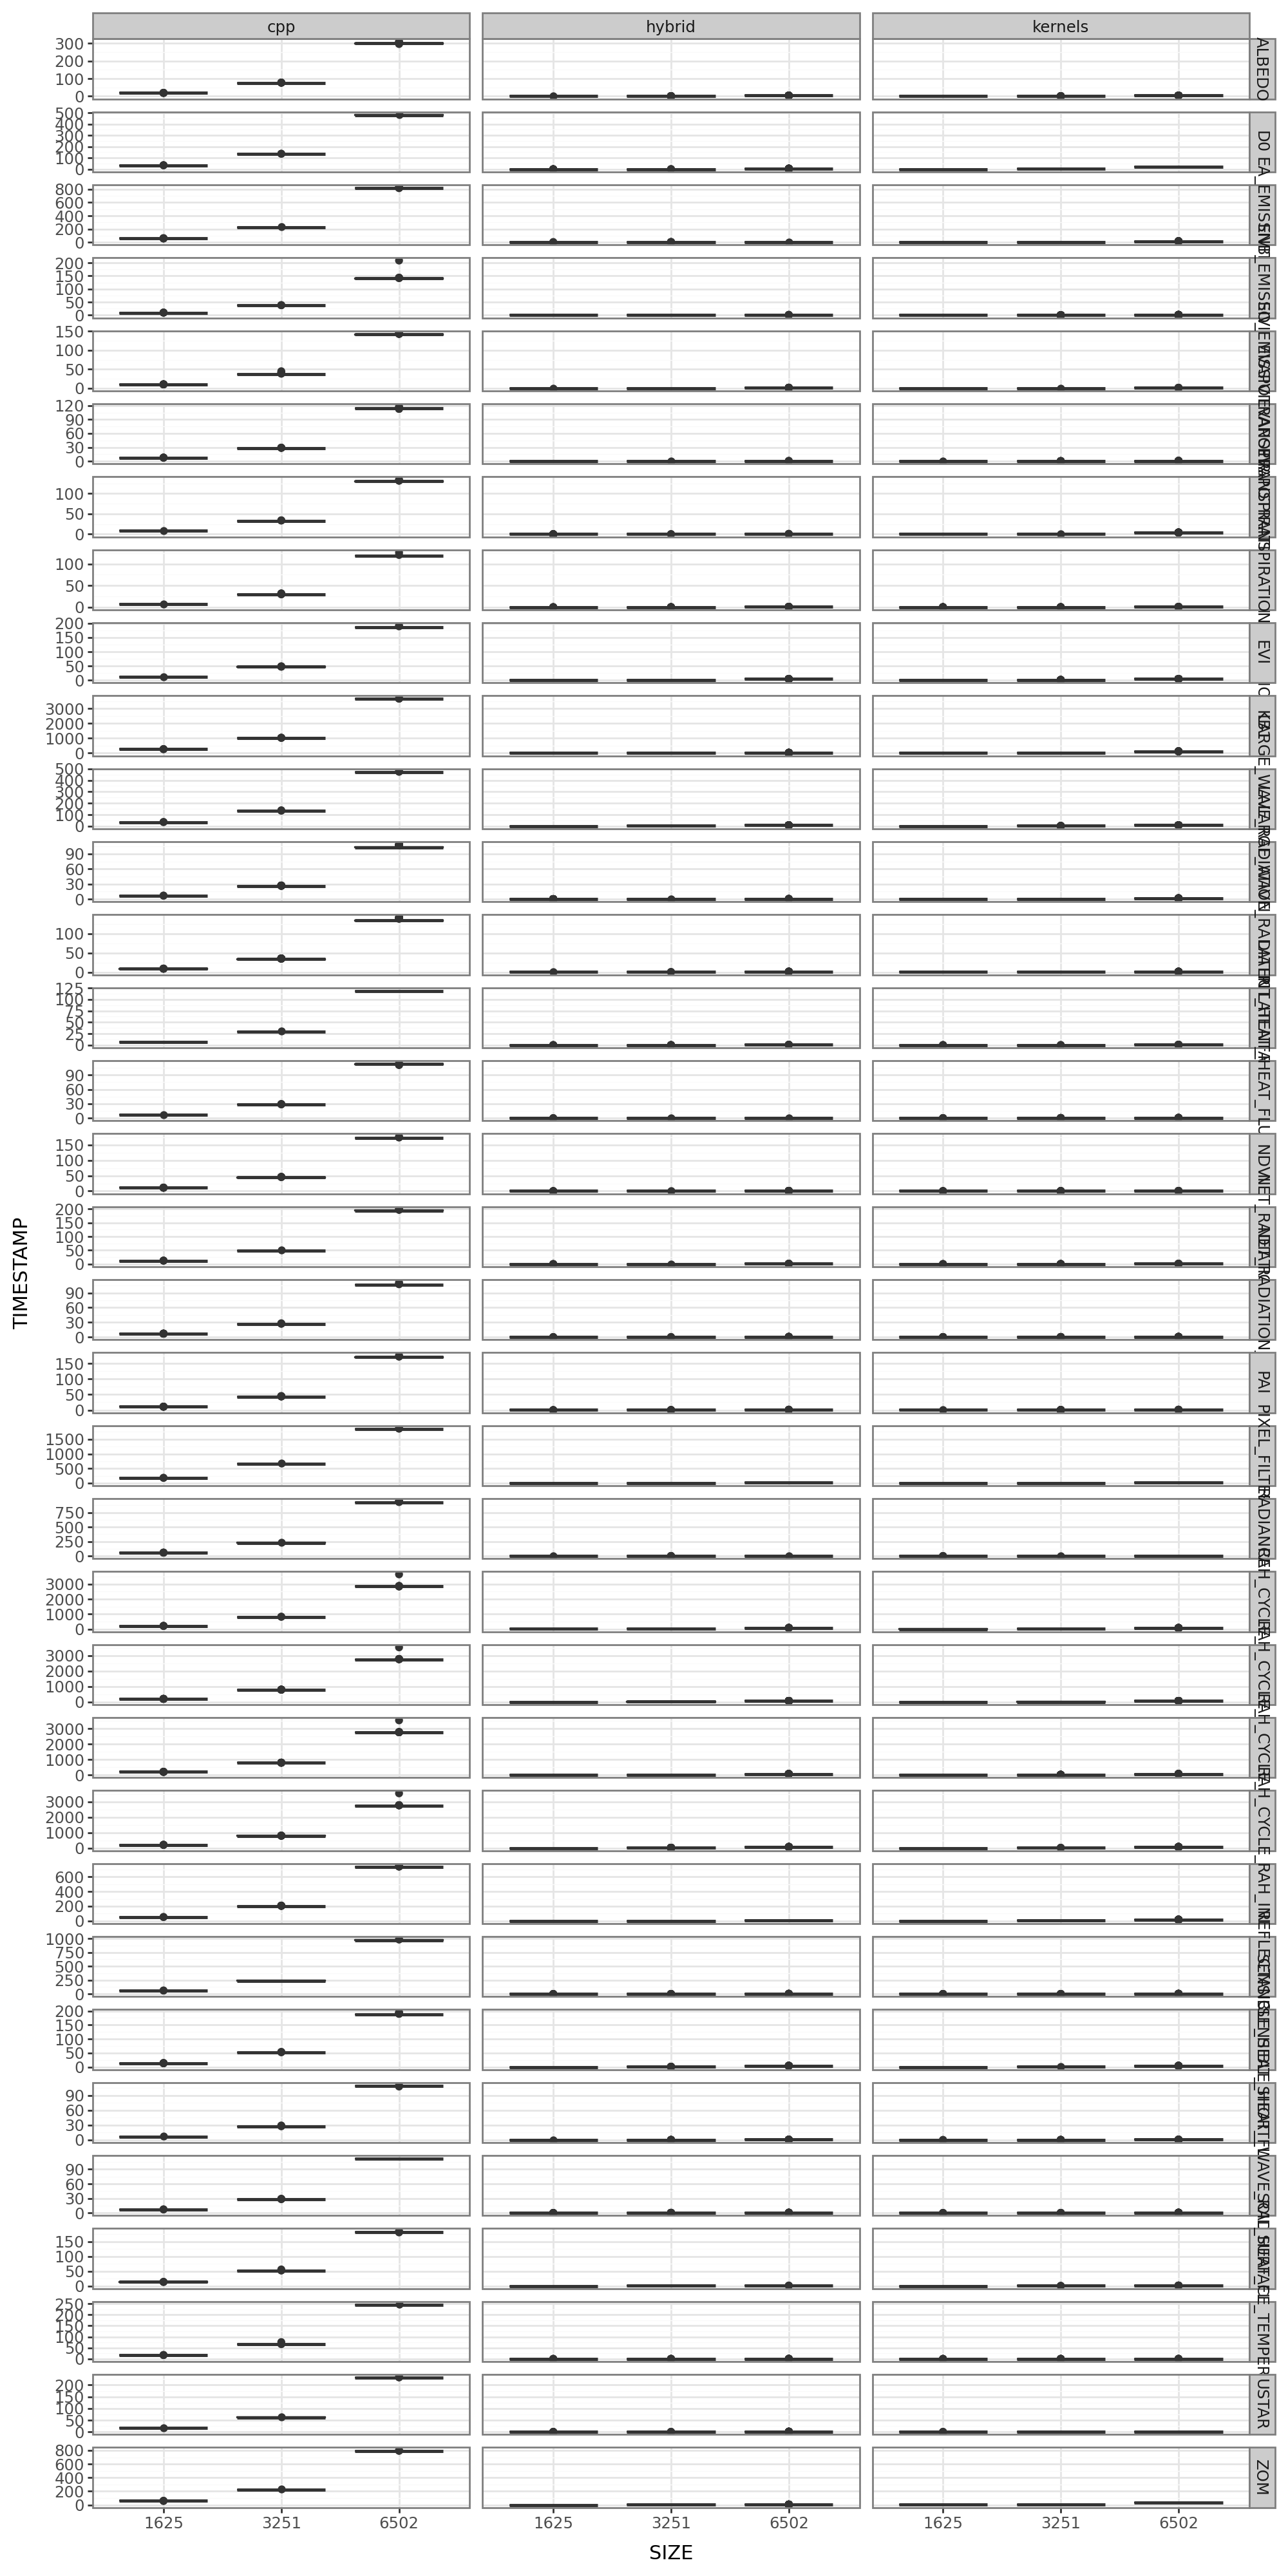

In [83]:
options.figure_size = (10, 20)

(ggplot(sebal, aes(x='SIZE', y='TIMESTAMP'))
 + geom_boxplot()
 + facet_grid("PHASE ~ LANG", scales='free')
 + theme_bw())

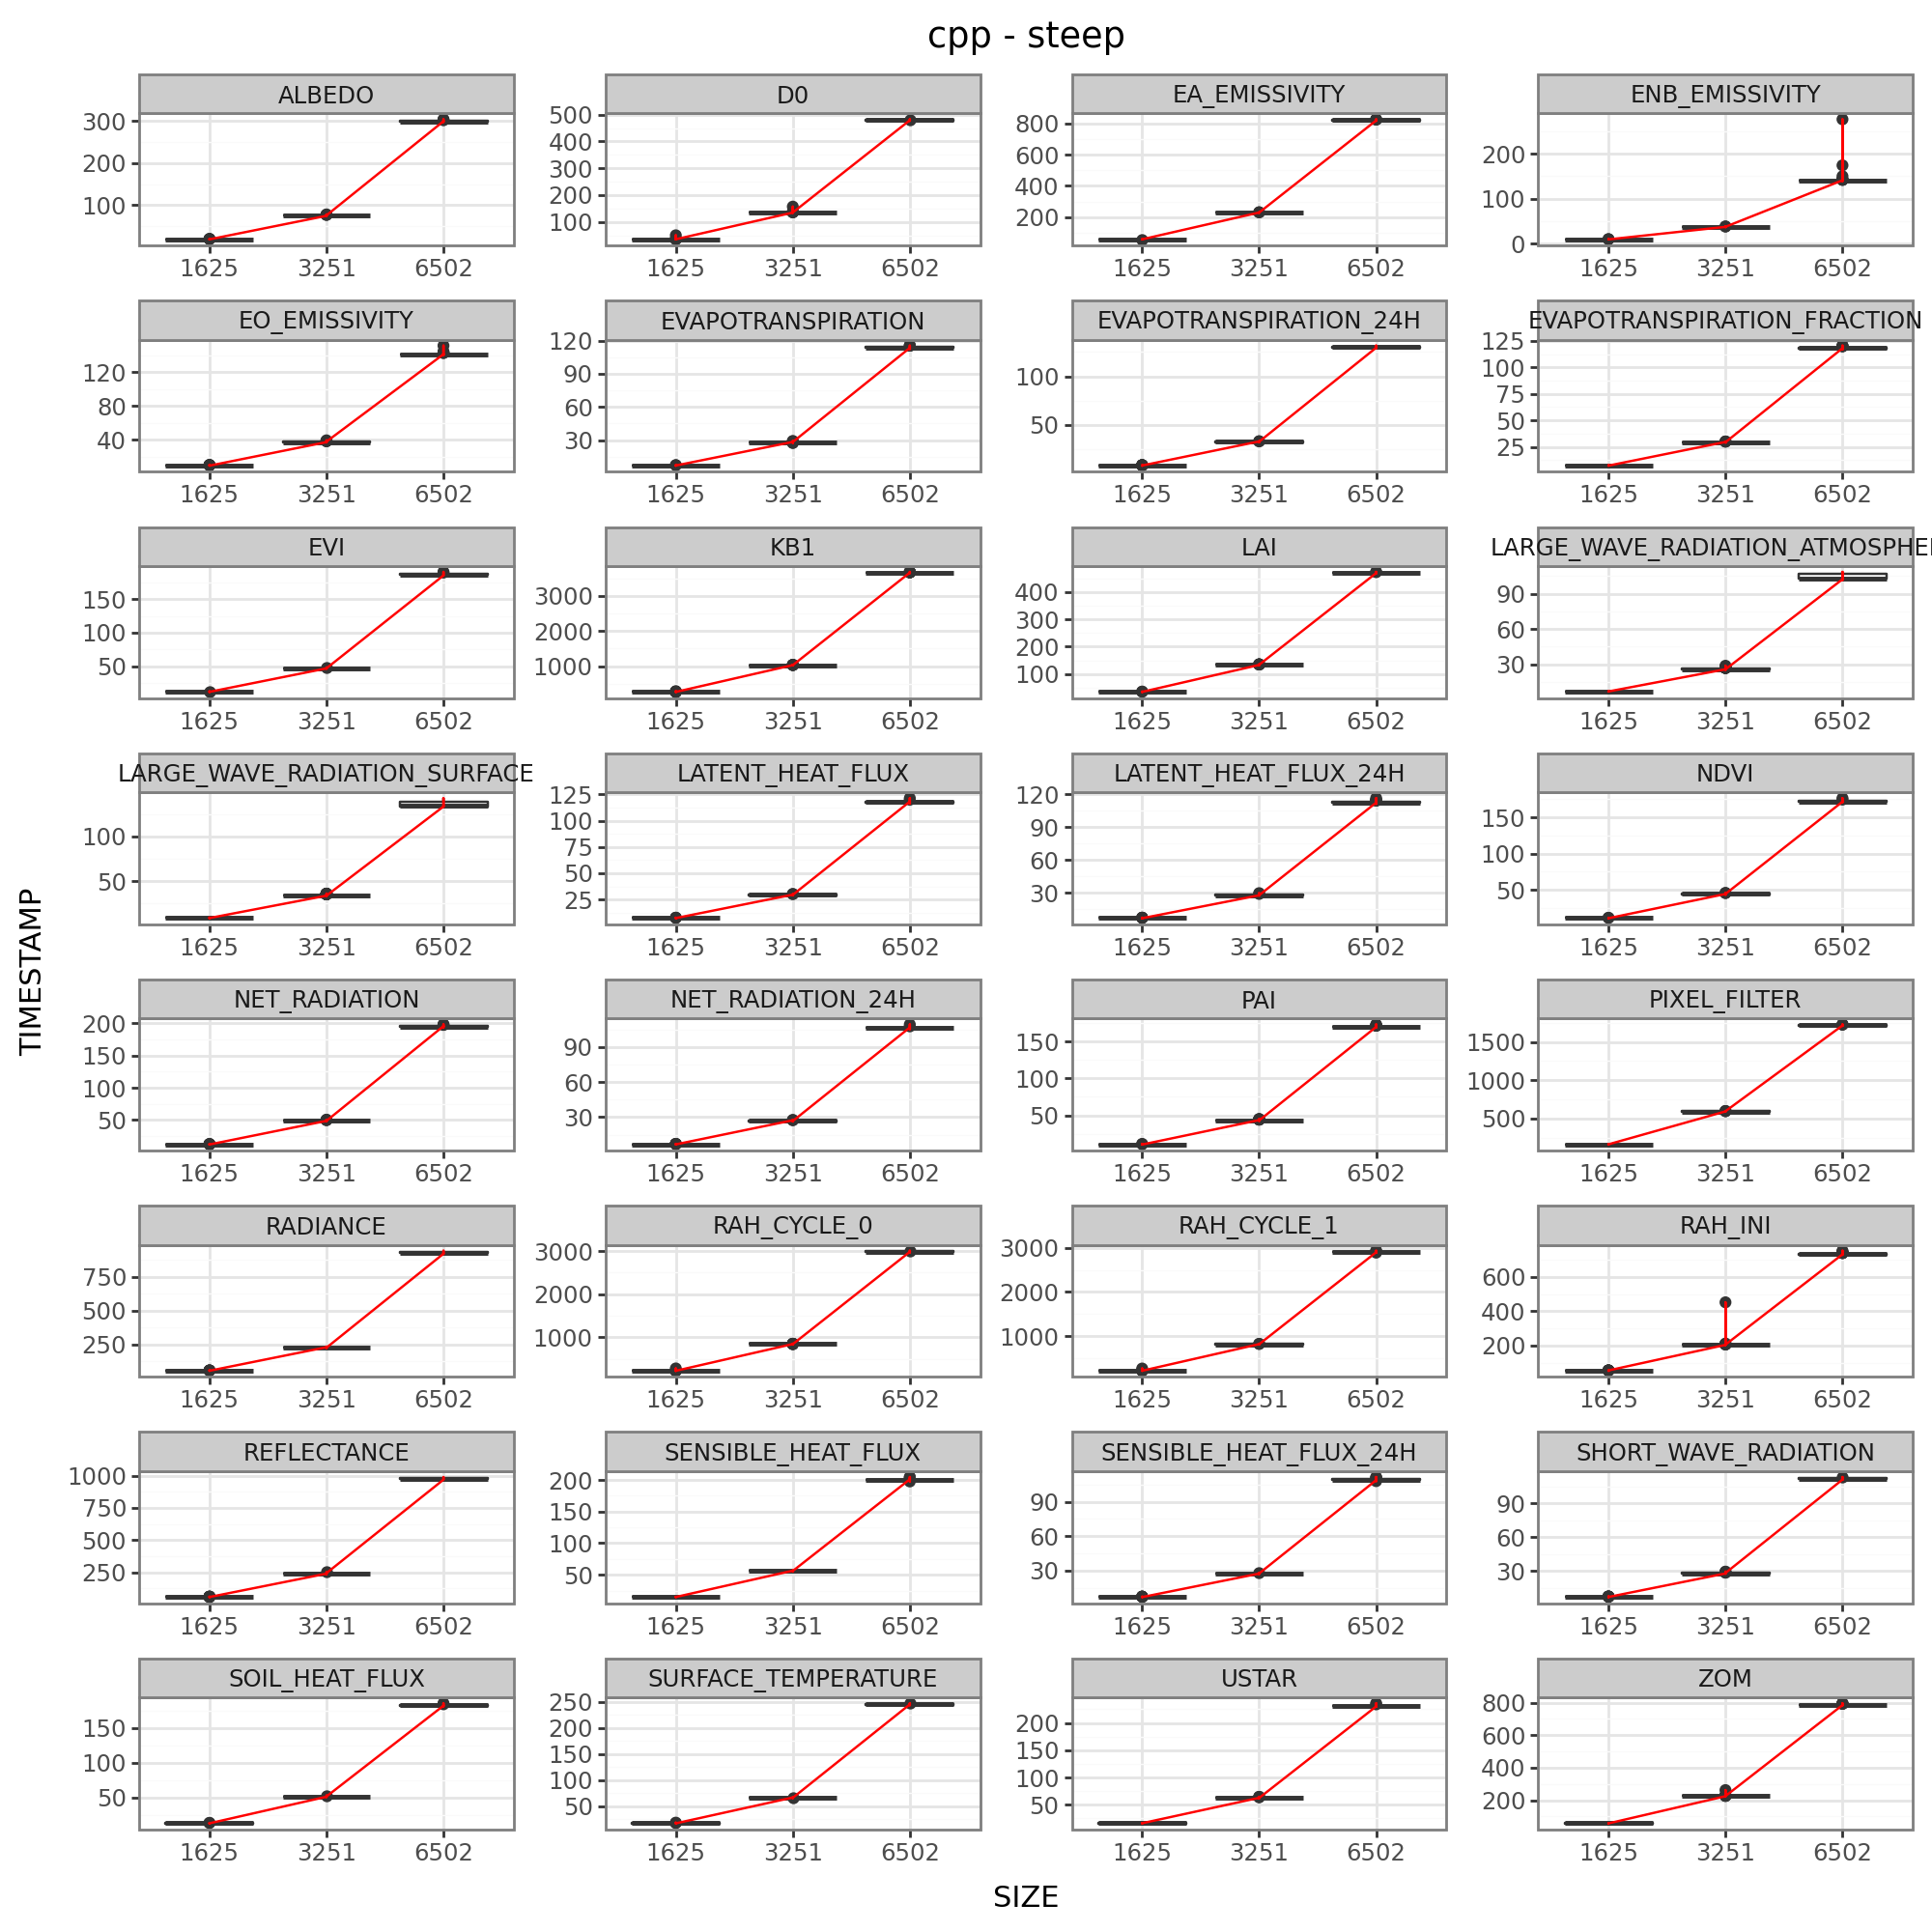

In [82]:
options.figure_size = (10, 10)

(ggplot(cpp_steep, aes(x='SIZE', y='TIMESTAMP'))
 + geom_boxplot()
 + geom_line(aes(group='PHASE'), color='red')
 + facet_wrap(" ~ PHASE", ncol=4, scales='free')
 + labs( title=f"{cpp_steep['LANG'].iloc[0]} - {cpp_steep['METHOD'].iloc[0]}")
 + theme_bw())

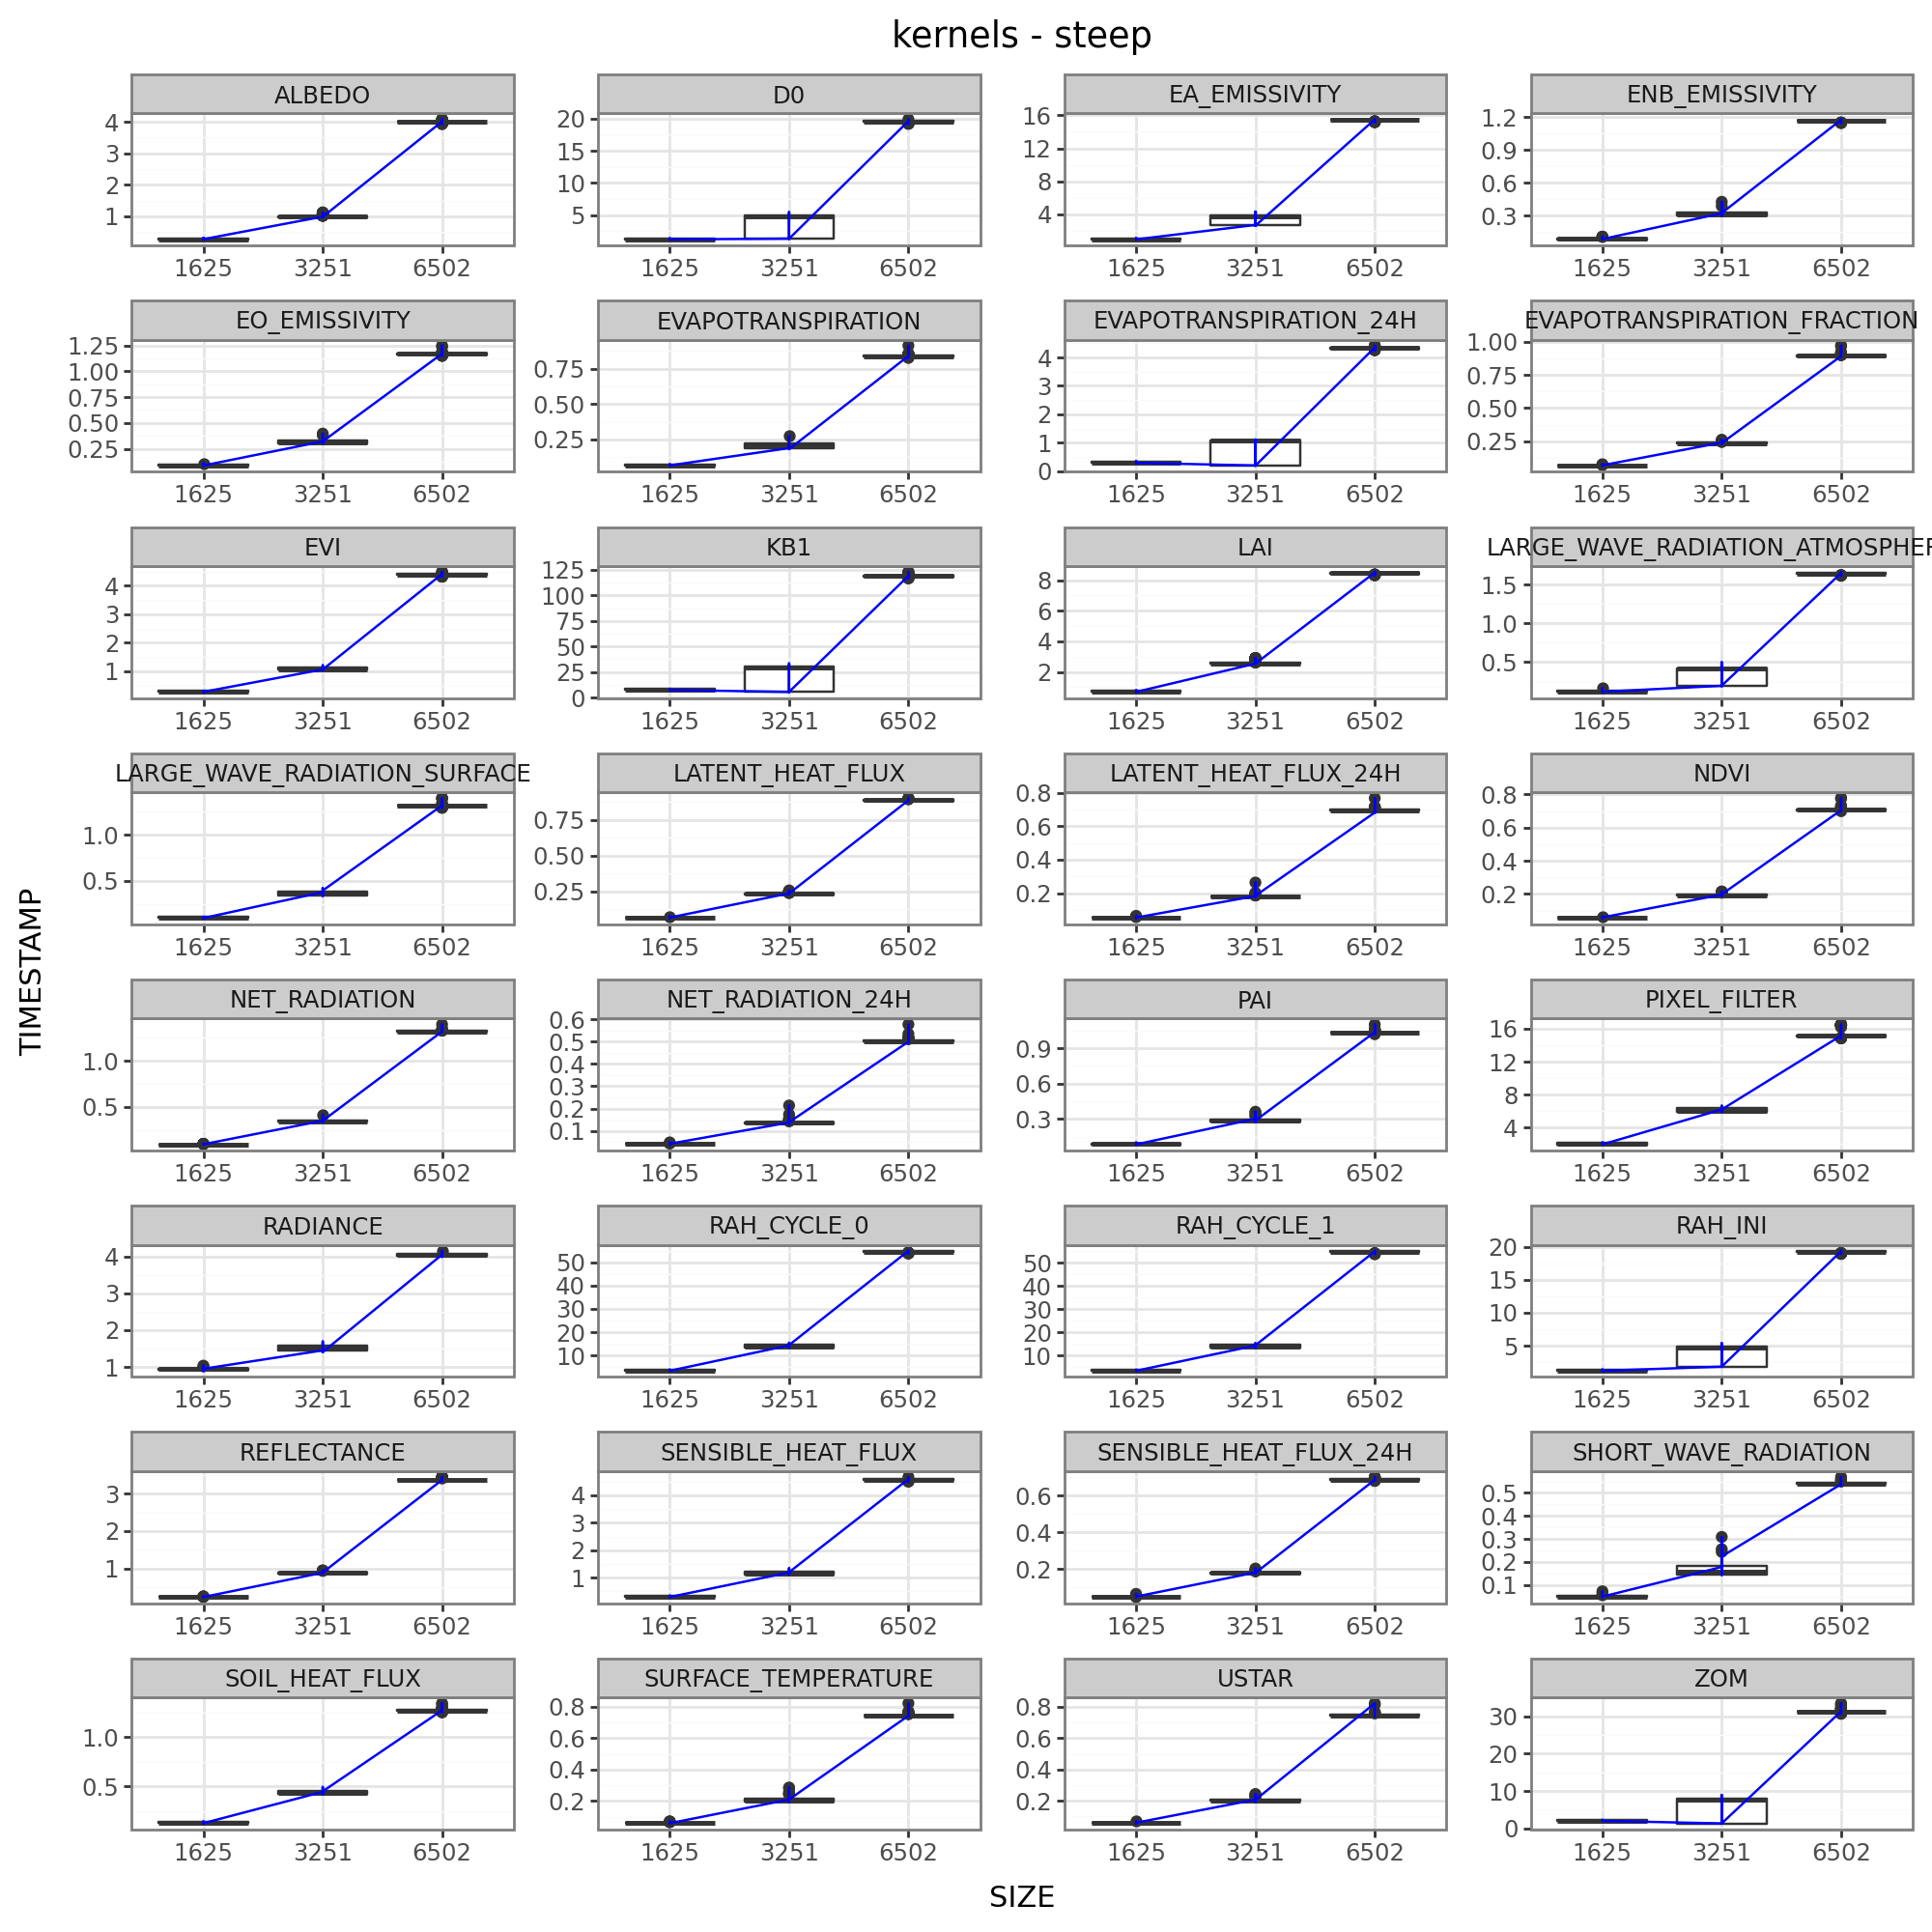

In [84]:
options.figure_size = (10, 10)

(ggplot(kernels_steep, aes(x='SIZE', y='TIMESTAMP'))
 + geom_boxplot()
 + geom_line(aes(group='PHASE'), color='blue')
 + facet_wrap(" ~ PHASE", ncol=4, scales='free')
 + labs( title=f"{kernels_steep['LANG'].iloc[0]} - {kernels_steep['METHOD'].iloc[0]}")
 + theme_bw())

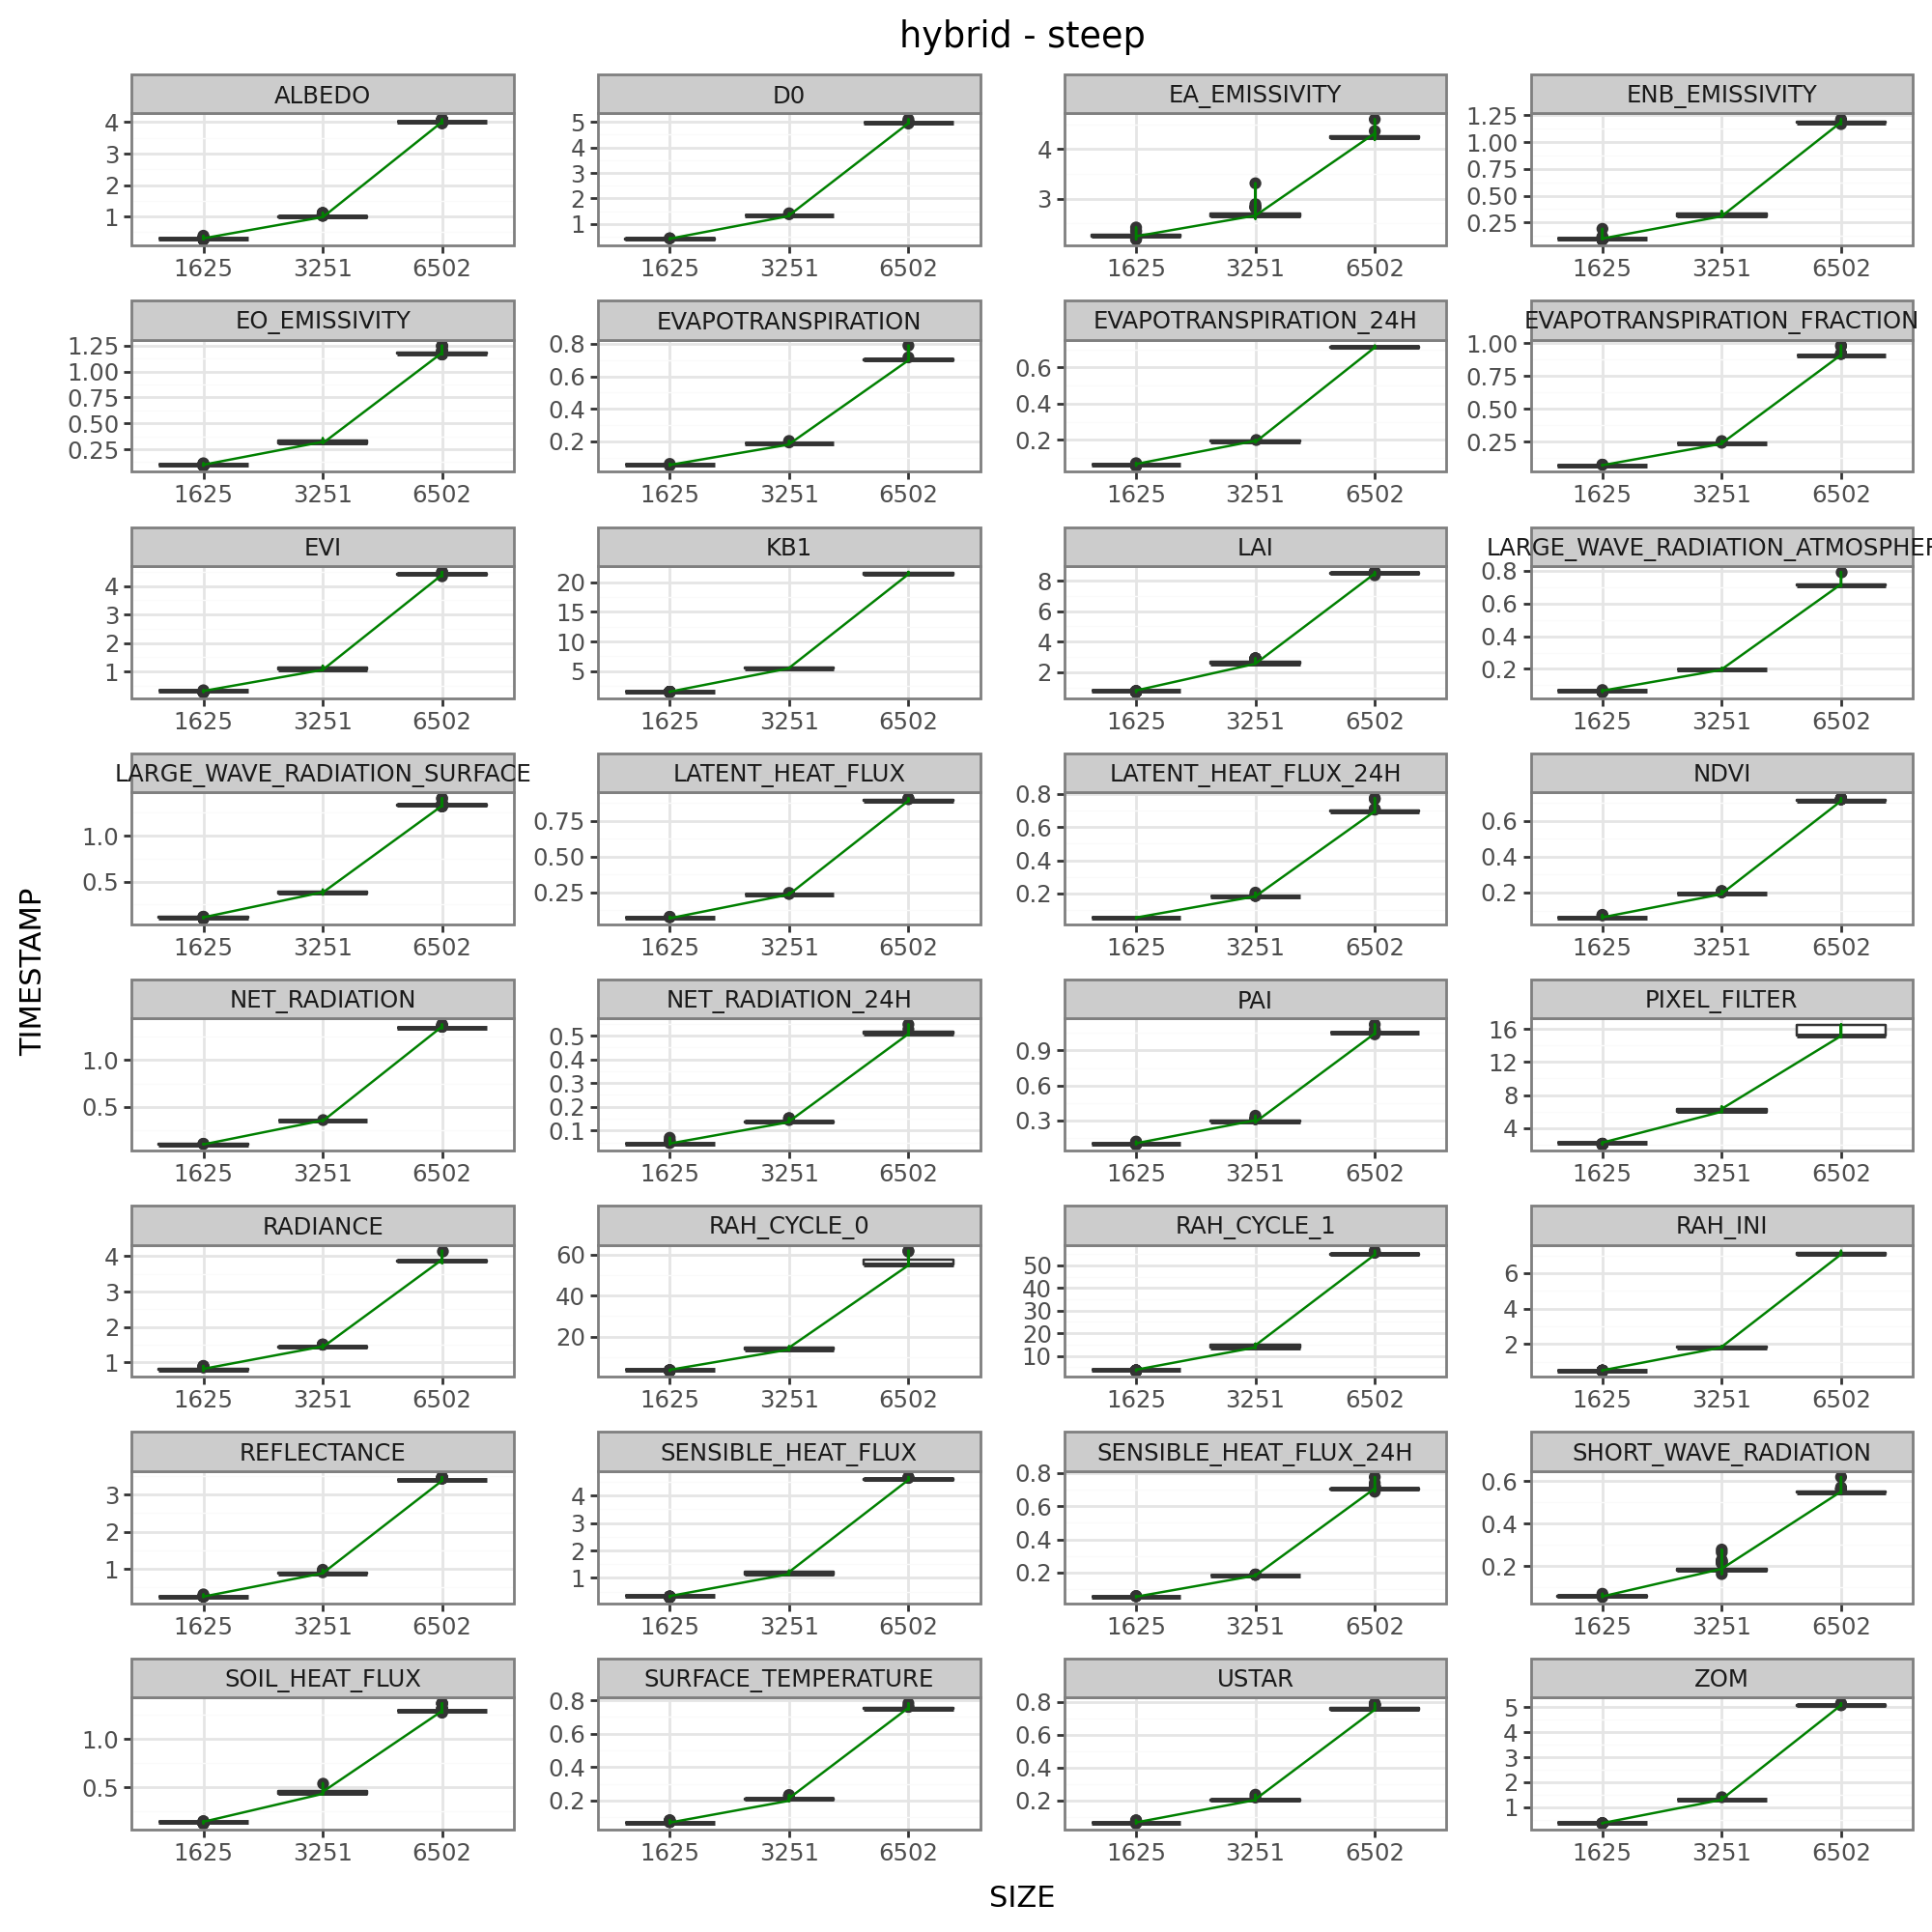

In [85]:
options.figure_size = (10, 10)

(ggplot(hybrid_steep, aes(x='SIZE', y='TIMESTAMP'))
 + geom_boxplot()
 + geom_line(aes(group='PHASE'), color='green')
 + facet_wrap(" ~ PHASE", ncol=4, scales='free')
 + labs( title=f"{hybrid_steep['LANG'].iloc[0]} - {hybrid_steep['METHOD'].iloc[0]}")
 + theme_bw())